## Email Spam Detection

Overall approach to develop the model are:
1.  Python Packages
2.  Data & Reading Data
3. Exploratory Data Analysis & Feature Engineering
  * Summary Statistics & Information
  * Label Variable & Distribution
  * Text Processing & Word Cloud
4.  Model Development 
  * Text Data manifestation using Tf-IDF
  * Split Data
  * Model Development - Naive Base
  * Model Validation



## Python Packages

In [1]:
import os
import email
import random
import email.policy
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import sklearn
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


## Read Data

In [2]:
# Define folder path
base_directory = "../input/ham-and-spam-dataset/"
spam_emails = os.listdir(base_directory + "spam")
ham_emails = os.listdir(base_directory + "ham")
# Read the emails
def load_email(is_spam, filename):
    directory = base_directory + ("spam" if is_spam else "ham")
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
spam_emails = [load_email(True, filename) for filename in spam_emails]
ham_emails = [load_email(False, filename) for filename in ham_emails]

print("# of SPAM emails", len(spam_emails))
print("# of HAM emails", len(ham_emails))



# of SPAM emails 501
# of HAM emails 2551


Processing each email and get the contents of the emails

In [3]:
def process_email(emails, label, data_dictionary, default_topic=None):
    for mail in emails:
        payload = mail.get_payload()
        if isinstance(payload, list):
            process_email(payload, label, data_dictionary, default_topic=mail["Subject"])
        else:
            if "Content-Type" in mail.keys():
                if "html" in mail["Content-Type"].lower():
                    try: 
                        soup = BeautifulSoup(mail.get_content())
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = soup.body.text
                        data_dictionary["subject"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                    except:
                        pass
                elif "plain" in mail["Content-Type"].lower():
                    try: 
                        topic = mail["Subject"]
                        if topic == None:
                            topic = default_topic
                        content = mail.get_content()
                        data_dictionary["subject"].append(topic)
                        data_dictionary["content"].append(content)
                        data_dictionary["label"].append(label)
                    except:
                        pass
                else:
                    pass

# define disctionary stucture
emails_dictionary = {"subject": [], "content": [], "label": []}
# Get Email Contents
process_email(spam_emails, 1, emails_dictionary)
process_email(ham_emails, 0, emails_dictionary)
# Convert Dictionaryt o DataFrame
emails_df = pd.DataFrame(emails_dictionary)
emails_df.head()


,subject,content,label
0,Teach and Grow Rich,\r\n Do You Want To Teach and...,1
1,A marketplace where lenders compete for your b...,\n\n\n\nCopyright 2002 - All rights reservedIf...,1
2,"Adv: Mortgage Quotes Fast Online, No Cost",\n\nIf this promotion has reached you in error...,1
3,$10 a hour for watching e-mmercials! No joke!,\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nUnlist Info...,1
4,Re: Your VIP Pass,###################################\n\n FREE ...,1


## 2.Exploratory Data Analysis & Feature Engineering

Now, we have the dataset with us, and it is always important to carry out Exploratory Data Analysis (EDA). There may be some insights and idea we get to improve the data.
For a classification problem like Spam Classification, we must always check the label data distribution. We can visualize spam/ham emails using a bar chart.


In [4]:
emails_df['label'].value_counts()

0    2166
1     502
Name: label, dtype: int64

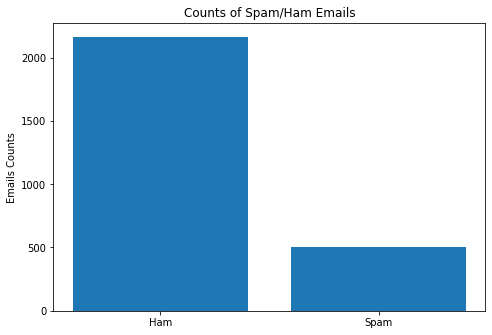

In [5]:
fig = plt.figure()
# plt.figure(figsize=(1,1))
ax = fig.add_axes([0,0,1,1])
labels = ['Ham', 'Spam']
ax.bar(labels,emails_df['label'].value_counts())
plt.ylabel('Emails Counts')
plt.title('Counts of Spam/Ham Emails')
plt.show()


Text Data Pre-processing: Emails
Since, we have text contents for each of these emails. We need to clean up the text data and some of the basic steps are

* Convert to lowercase
* Remove stop words
* Remove non relevant contents such as https
* Convert words to their base form – lemmatization 


In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = re.sub(r"(\#\w+)", "", text)
    text = re.sub(r"(\@\w+)", "", text)
    text = re.sub(r"\S*https?:\S*", "", text)
    text = re.sub("http\S+","",text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(' s ',' ',text)
    text = re.sub(r"rt ", "", text)
    text = text.lstrip().rstrip()
    return text


In [7]:
cleaned_content_list=[]
for s in emails_df['content']:
    try:
        cleaned_content_list.append(clean_text(s))
    except:
        cleaned_content_list.append("")

cleaned_content_list[:5]


['do you want to teach and grow rich if you are a motivated and qualified communicator i will personally train you to do minutes presentations per day to qualify prospects that i can provide to you we will demonstrate to you that you can make a day patime using this system or if you have hours per week as in my case you can make in excess of per week as i am currently generating verifiable by the way plus i will introduce you to my mentor who makes well in excess of annually many are called few are chosen this opportunity will be limited to one qualified individual per state make the call and call the hour pre recorded message number below we will take as much or as little time as you need to see if this program is right for you please do not make this call unless you are genuinely money motivated and qualified i need people who already have people skills in place and have either made large amounts of money in the past or are ready to generate large amounts of money in the future looki

In [8]:
# remove stop words
content_stopwords= [[wd for wd in sent.split() if wd not in stop_words] for sent in cleaned_content_list]

# Remove words with 3 characters
content_keepwords= [[ wd for wd in sent if len(wd)>3] for sent in content_stopwords]

# Lemmatize words
content_lemms= [[ wordnet_lemmatizer.lemmatize(wd,pos="v") for wd in sent ] for sent in content_keepwords]
content_lemms1= [[ wordnet_lemmatizer.lemmatize(wd,pos="n") for wd in sent ] for sent in content_lemms]

content_lemms1[:1]


[['want',
  'teach',
  'grow',
  'rich',
  'motivate',
  'qualify',
  'communicator',
  'personally',
  'train',
  'minute',
  'presentation',
  'qualify',
  'prospect',
  'provide',
  'demonstrate',
  'make',
  'patime',
  'use',
  'system',
  'hour',
  'week',
  'case',
  'make',
  'excess',
  'week',
  'currently',
  'generate',
  'verifiable',
  'plus',
  'introduce',
  'mentor',
  'make',
  'well',
  'excess',
  'annually',
  'many',
  'call',
  'choose',
  'opportunity',
  'limit',
  'qualify',
  'individual',
  'state',
  'make',
  'call',
  'call',
  'hour',
  'record',
  'message',
  'number',
  'take',
  'much',
  'little',
  'time',
  'need',
  'program',
  'right',
  'please',
  'make',
  'call',
  'unless',
  'genuinely',
  'money',
  'motivate',
  'qualify',
  'need',
  'people',
  'already',
  'people',
  'skill',
  'place',
  'either',
  'make',
  'large',
  'amount',
  'money',
  'past',
  'ready',
  'generate',
  'large',
  'amount',
  'money',
  'future',
  'look',
 

Convert the word list to text.

In [9]:
# Convert to text
from itertools import chain
df_text =pd.DataFrame({'col':content_lemms1})

content_word_list = list(chain.from_iterable(df_text.col.values))
content_words = ' '.join(content_word_list)
# Bigram
bgram = TextBlob(content_words).ngrams(2)
bgram[:5]

[WordList(['want', 'teach']),
 WordList(['teach', 'grow']),
 WordList(['grow', 'rich']),
 WordList(['rich', 'motivate']),
 WordList(['motivate', 'qualify'])]

In [10]:
word_dict  = [' '.join(tup) for tup in list(bgram)]
print (len(word_dict))
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(word_dict)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)


288901


### Word Cloud
Word Cloud helps in understanding the common words across the text corpus. For developing the word cloud, we need to find words and their frequencies. Then plot the relative importance using word cloud. So, we need to find N-Gram of the text documents.


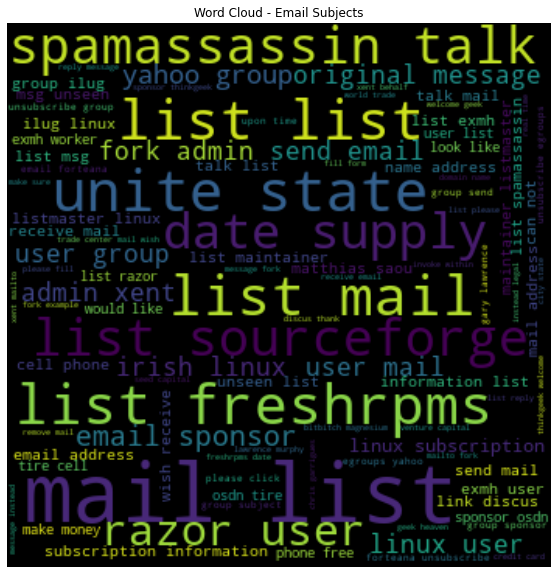

In [11]:
fig = plt.figure(figsize=(10,10))
words_dict = dict(words_freq[:200])
wordCloud = WordCloud(max_words=100, height=350, width=350,stopwords=stop_words)
wordCloud.generate_from_frequencies(words_dict)
plt.title('Word Cloud - Email Subjects')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We should split the data into Spam and Ham, and then prepare word cloud for each of them. This will help us in finding the word difference between these two.

## 4. Model Development

### TF IDF
For the model, the input data should be representation numerically. In this case we will convert the subjects’ textual information to a numerically format. For now, the data will be converted into either Tf-IDF vectors or word vector count. We will use Tf-IDF Vectorizer on the email subject data.
TF-IDF Vectorizer creates Tf-IDF values for every word in the email subjects. Tf-IDF values gives a higher value to words appearing less frequently so that commonly occurring words don’t give importance to them but gives more importance to the meaningful and interesting terms used in the email subjects

Term frequency (TF) = (Number of Occurrences of a word)/(Total words in the document)

IDF(word) = Log((Total number of documents)/(Number of documents containing the word))


In [12]:
tfidfconverter = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
content_idf = tfidfconverter.fit_transform(cleaned_content_list).toarray()

content_idf[:10]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
content_idf.shape

(2668, 1000)

### Model Samples/Split Datta

In [14]:
# labels
y = emails_df['label']
X_train, X_test, y_train, y_test = train_test_split(content_idf, y, test_size=0.2, random_state=0)
print("Length of Train", len(X_train))
print("Length of Train", len(X_test))


Length of Train 2134
Length of Train 534


### Training Text Classification Model - Spam Vs Ham

We can use any of the supervised ML method that can be used for classification. Let's first fit our Naïve Bayes model, on the Tf-IDF vector-based x_train and labelled sample - y_train.


In [15]:
#Create a Gaussian Classifier
modelNB = GaussianNB()
# Train the model using the training sets
modelNB.fit(X_train,y_train)

GaussianNB()

Predict label for training sample

In [16]:
yTrain_pred = modelNB.predict(X_train)

### Model Performance Metrics

<AxesSubplot:>

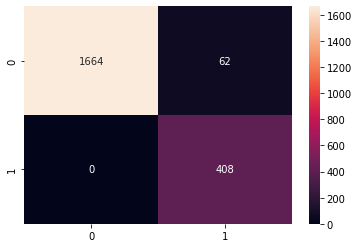

In [17]:
cm = sklearn.metrics.confusion_matrix(y_train, modelNB.predict(X_train))
sns.heatmap(cm, annot=True, fmt="d")

In [18]:
print(confusion_matrix(y_train,yTrain_pred))
print(classification_report(y_train,yTrain_pred))
print(accuracy_score(y_train,yTrain_pred))


[[1664   62]
 [   0  408]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1726
           1       0.87      1.00      0.93       408

    accuracy                           0.97      2134
   macro avg       0.93      0.98      0.96      2134
weighted avg       0.97      0.97      0.97      2134

0.9709465791940018


**Precision** tells us % of cases correctly identified. For the emails predicted as Spam, % of these are Spam. In the above confusion matrix, 87% of the emailed identified by the model as Spam are correctly classified.

**Recall** is termed as capture rate. In this example, % of all the Spam emailed captured by the model. In the above example, all the Spam emailed are identified. So, for Spam (label =1), the call is 1.

Since Precision is only 87% for the Spam class, we can find ways to improve the model.
by Asif Javed

## Concluding thoughts and next steps
We have learnt steps to develop an email classification model that can classify emails into Spam or Ham. 

You can follow the steps to use email content and subject (both together) to improve the accuracy of the model.

Also there are multipleways to improve the model performance further
